# Construct the hybrid graph representation of a 2D cartesian map

In [6]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
from panav.tunnels import detect_tunnels

import shapely
import numpy as np
from matplotlib import pyplot as plt

from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely import Polygon,LineString,Point


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: detect tunnels in the environment

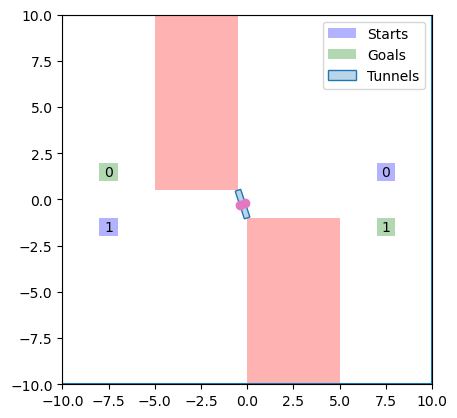

In [24]:
start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])


start_locs = np.array([[5,1],[-5,-1]])*1.5
goal_locs = np.array([[-5,1],[5,-1]])*1.5


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-5.0,-0.5),(0.5,10))
O2 = Box2DRegion((-0.0,5.0),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

ax = plt.gca()

draw_env(env,ax=ax)
        

labeled = False
tunnels = detect_tunnels(env,bloating_r)
for tunnel in tunnels:
    plot_polygon(tunnel.region,ax=ax,label='Tunnels' if not labeled else None,add_points =False)
    ent_pts = np.array(tunnel.end_points)
    plt.scatter(ent_pts[:,0],ent_pts[:,1])

    labeled=True
    
ax.legend()
plt.show()

## Step 2: assign locations to nodes in the hybrid graph

In [43]:
import networkx as nx
G = nx.DiGraph()
nx.set_node_attributes(G,(0,0),'loc') # Every node has a location attribute: loc \in R^d.
nx.set_node_attributes(G,'','type') # Every node has a type attribute: type \in {'start','goal','tunnel'}. Tunnel endpoints are of type 'tunnel'
nx.set_edge_attributes(G,'','type') # Every edge has a hardness attribute: type \in {'soft','hard'}.

for i,tunnel in enumerate(tunnels): # Add hard edges + tunnel nodes
    u = 2*i
    v = 2*i+1
    
    G.add_node(u,type='tunnel',loc = tunnel.end_points[0])
    G.add_node(v,type='tunnel',loc = tunnel.end_points[1])

    G.add_edge(u,v,type='hard')
    G.add_edge(v,u,type='hard')
    

In [44]:
from itertools import product
# Add start nodes
G.add_nodes_from(np.arange(G.number_of_nodes(),
                    G.number_of_nodes() \
                    +len(start_locs)), type = 'start',loc = start_locs )

# Add goal nodes
G.add_nodes_from(np.arange(G.number_of_nodes(),
                    G.number_of_nodes() \
                    +len(goal_locs)), type = 'goal',loc = goal_locs )

# Add soft edges

for u,v in product(G.nodes,G.nodes):
    if not (u,v) in G.edges and not G.nodes[u]['type'] == G.nodes[v]['type'] :
        G.add_edge(u,v,type = 'soft')
        G.add_edge(v,u,type = 'soft')
        print((u,v))

(0, 2)
(0, 3)
(0, 4)
(0, 5)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 0)
(2, 1)
(2, 4)
(2, 5)
(3, 0)
(3, 1)
(3, 4)
(3, 5)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(5, 0)
(5, 1)
(5, 2)
(5, 3)


In [40]:
G.nodes(data=True)

NodeDataView({0: {'loc': array([-0.39823, -0.29941])}, 1: {'loc': array([-0.10177, -0.20059])}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {'type': 'start'}, 7: {'type': 'start'}, 8: {'type': 'goal'}, 9: {'type': 'goal'}})